# Setup

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [5]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'mobilenetv3Large_10split_LRStr.hdf5'

In [6]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet_v3.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [7]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [8]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [9]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [10]:
any(elem is None for elem in train_img_lst)

False

In [11]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [12]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [13]:
any(elem is None for elem in val_img_lst)

False

In [14]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [15]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [16]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [17]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [18]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [19]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [20]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [21]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [22]:
MobileNetV3Large = tf.keras.applications.MobileNetV3Large(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,

)

inputs['image'] = MobileNetV3Large.input

# Exclude the last 28 layers of the model.
MobileNetV3Large_output = MobileNetV3Large.layers[-2].output

## Final Model

In [23]:
#attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(MobileNetV3Large_output.shape[-1]),name='soft_attention')(MobileNetV3Large_output)
#attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
#MobileNetV3Large_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(MobileNetV3Large_output))

#MobileNetV3Large_output = layers.Concatenate()([MobileNetV3Large_output, attention_layer])
#MobileNetV3Large_output = Activation('relu')(MobileNetV3Large_output)
#MobileNetV3Large_output = Dropout(0.5)(MobileNetV3Large_output)

In [24]:
#output = Flatten()(MobileNetV3Large_output)
#preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
#output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(MobileNetV3Large_output)
model = Model(inputs=inputs, outputs=output)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_5 (ReLU)                 (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_10 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 multiply_4 (Multiply)          (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_22[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_10[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_14[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_15[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 

 tf.math.multiply_25 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_36[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_18 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

                                                                                                  
 sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 7)            7007        ['flatten[0][0]']                
                                                                                                  
Total params: 5,514,439
Trainable params: 5,490,039
Non-trainable params: 24,400
__________________________________________________________________________________________________


## Training

In [26]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [27]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [28]:
class_weights = { 
                    0: 0.13,  # akiec
                    1: 0.08,  # bcc
                    2: 0.04,  # bkl
                    3: 0.38,  # df
                    4: 0.03,  # mel
                    5: 0.006,  # nv
                    6: 0.31,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [29]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [31]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 537s 521ms/step - loss: 0.0606 - accuracy: 0.1473 - val_loss: 2.3391 - val_accuracy: 0.1486 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 465s 519ms/step - loss: 0.0438 - accuracy: 0.3379 - val_loss: 1.7892 - val_accuracy: 0.3273 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 453s 506ms/step - loss: 0.0353 - accuracy: 0.4805 - val_loss: 1.3806 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 453s 505ms/step - loss: 0.0307 - accuracy: 0.5547 - val_loss: 1.2000 - val_accuracy: 0.5572 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 450s 502ms/step - loss: 0.0273 - accuracy: 0.6064 - val_loss: 1.0981 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 468s 522ms/step - loss: 0.0238 - accuracy: 0.6281 - val_loss: 1.0389 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 7/500
896/896 [===================

Epoch 52/500
896/896 [==============================] - 381s 425ms/step - loss: 0.0052 - accuracy: 0.8555 - val_loss: 0.6036 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 53/500
896/896 [==============================] - 385s 430ms/step - loss: 0.0055 - accuracy: 0.8509 - val_loss: 0.6065 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 54/500
896/896 [==============================] - 385s 430ms/step - loss: 0.0050 - accuracy: 0.8625 - val_loss: 0.5892 - val_accuracy: 0.7952 - lr: 0.0010
Epoch 55/500
896/896 [==============================] - 385s 429ms/step - loss: 0.0049 - accuracy: 0.8604 - val_loss: 0.5933 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 56/500
896/896 [==============================] - 421s 470ms/step - loss: 0.0052 - accuracy: 0.8559 - val_loss: 0.6033 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 57/500
896/896 [==============================] - 361s 403ms/step - loss: 0.0047 - accuracy: 0.8660 - val_loss: 0.5946 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 58/500
896/896 [============

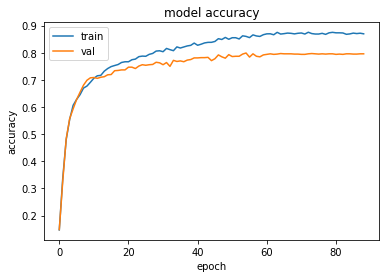

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

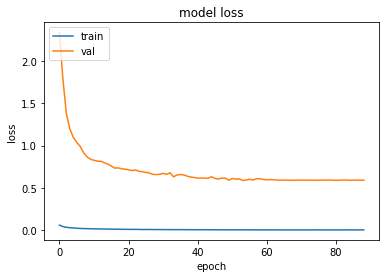

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
from tensorflow.keras import models
model.load_weights(model_path)

In [35]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [36]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.53      0.70      0.61        33
         bcc       0.66      0.75      0.70        51
         bkl       0.61      0.72      0.66       109
          df       0.50      0.83      0.62        12
         mel       0.50      0.58      0.54       111
          nv       0.94      0.85      0.90       666
        vasc       0.82      1.00      0.90        14

    accuracy                           0.80       996
   macro avg       0.65      0.77      0.70       996
weighted avg       0.82      0.80      0.81       996



# Confusion Matrix Metrics

In [37]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [38]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [39]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[943  20]
 [ 10  23]]
True Positive of akiec: 23
False Positive of akiec: 20
False Negative of akiec: 10
True Negative of akiec: 943
Sensitivity of akiec: 0.696969696969697
Specificity of akiec: 0.9792315680166147
Precision of akiec: 0.5348837209302325
Accuracy of akiec: 0.9698795180722891
Balanced Accuracy of akiec : 0.8381006324931559
F1 Score of akiec: 0.6052631578947368


### bcc       

In [40]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[925  20]
 [ 13  38]]
True Positive of bcc: 38
False Positive of bcc: 20
False Negative of bcc: 13
True Negative of bcc: 925
Sensitivity of bcc: 0.7450980392156863
Specificity of bcc: 0.9788359788359788
Precision of bcc: 0.6551724137931034
Accuracy of bcc: 0.9668674698795181
Balanced Accuracy of bcc : 0.8619670090258326
F1 Score of bcc: 0.6972477064220184


### bkl

In [41]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[838  49]
 [ 31  78]]
True Positive of bkl: 78
False Positive of bkl: 49
False Negative of bkl: 31
True Negative of bkl: 838
Sensitivity of bkl: 0.7155963302752294
Specificity of bkl: 0.9447576099210823
Precision of bkl: 0.6141732283464567
Accuracy of bkl: 0.9196787148594378
Balanced Accuracy of bkl : 0.8301769700981558
F1 Score of bkl: 0.6610169491525424


### df 

In [42]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[974  10]
 [  2  10]]
True Positive of df: 10
False Positive of df: 10
False Negative of df: 2
True Negative of df: 974
Sensitivity of df: 0.8333333333333334
Specificity of df: 0.9898373983739838
Precision of df: 0.5
Accuracy of df: 0.9879518072289156
Balanced Accuracy of df : 0.9115853658536586
F1 Score of df: 0.625


### mel

In [43]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[822  63]
 [ 47  64]]
True Positive of mel: 64
False Positive of mel: 63
False Negative of mel: 47
True Negative of mel: 822
Sensitivity of mel: 0.5765765765765766
Specificity of mel: 0.9288135593220339
Precision of mel: 0.5039370078740157
Accuracy of mel: 0.8895582329317269
Balanced Accuracy of mel : 0.7526950679493052
F1 Score of mel: 0.5378151260504201


### nv

In [44]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[295  35]
 [ 97 569]]
True Positive of nv: 569
False Positive of nv: 35
False Negative of nv: 97
True Negative of nv: 295
Sensitivity of nv: 0.8543543543543544
Specificity of nv: 0.8939393939393939
Precision of nv: 0.9420529801324503
Accuracy of nv: 0.8674698795180723
Balanced Accuracy of nv : 0.8741468741468741
F1 Score of nv: 0.8960629921259843


### vasc

In [45]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[979   3]
 [  0  14]]
True Positive of vasc: 14
False Positive of vasc: 3
False Negative of vasc: 0
True Negative of vasc: 979
Sensitivity of vasc: 1.0
Specificity of vasc: 0.9969450101832994
Precision of vasc: 0.8235294117647058
Accuracy of vasc: 0.9969879518072289
Balanced Accuracy of vasc : 0.9984725050916496
F1 Score of vasc: 0.9032258064516129


## Weighted, Macro, Micro, ROC AUC

In [46]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8221722311153044
Recall: 0.7991967871485943
Accuracy: 0.7991967871485943
weighted Roc score: 0.940962822779771


In [47]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.653392680405852
Recall: 0.7745611901035538
Accuracy: 0.7991967871485943
Macro Roc score: 0.9547544444431566


In [48]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.7991967871485943
Recall: 0.7991967871485943
Accuracy: 0.7991967871485943
Micro Roc score: 0.9712407192357113


In [49]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9765883130369112
The ROC AUC score of bcc is: 0.9705571117335823
The ROC AUC score of bkl is: 0.9188585376953549
The ROC AUC score of df is: 0.9910230352303524
The ROC AUC score of mel is: 0.8773960401079045
The ROC AUC score of nv is: 0.949003549003549
The ROC AUC score of vasc is: 0.9998545242944429


In [50]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

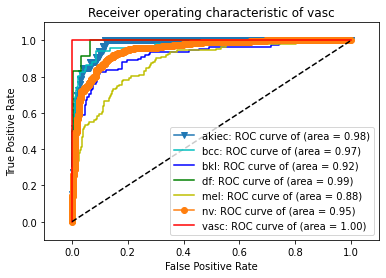

In [51]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()